# Analysis of Driving Factors 
In this notebook, we build a random forest regressor at the regional level to predict the annual VDI (Vegetation Density Index) at the 5km scale from the following driving factors:
- Total precipitation 
- Volumetric soil water layer 1 (0-7 cm) 
- Total evaporation (accumulated amount of water that has evaporated from the Earth's surface)
- Temperature of the soil in layer 1
- Air temperature at 2m above land surface
- 10m u-component of wind (eastward)
- 10m v-component of wind (northward)
- Soil type (ranging from 1 to 7)
- Evaporation from vegetation transpiration.
- Elevation
- Slope
- Aspect
- Population density per square km

Then, we apply the following techniques to evaluate the impact of each feature on the output:
- [RF Feature Importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html): global method where importances are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
- [Permutation Importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html):  global and model-agnostic method that overcomes the limitations of the impurity-based feature importance (don't have a bias toward high-cardinality features). It can be computed on a left-out test set.
- [SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations): model-agnostic method that uses a game-theoretic framework to elucidate the predictions of machine learning models, linking fair credit distribution to localized explanations by using classic Shapley values from game theory. Unlike previous approaches, it provides both local (sample level) and global explanations, as well as the direction of features' impact on predictions (i.e., negative and positive contributions).


In [2]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read raster files of driving factors

In [3]:
nb_years, nb_pixels_height, nb_pixels_width = 21, 126, 229
no_data = 255

climate_factors = ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'evaporation_from_vegetation_transpiration',
             'runoff', 'soil_temperature_level_1', 'soil_type',  'total_precipitation'
                , 'volumetric_soil_water_layer_1','total_evaporation',]
DEM_factors = ['aspect', 'slope', 'elevation']
livestock_factors = ['chicken', 'sheep', 'pigs', 'horses', 'goats', 'ducks', 'buffalos', 'cattle']
population_factors = ['population_density_GPWv4']

nb_factors = len(climate_factors) + len(DEM_factors)  + len(population_factors)
years = np.array([2002+i for i in range(nb_years)])
print(f'Total number of driving factors: {nb_factors}')
factors = np.ndarray((nb_factors,nb_years,nb_pixels_height,nb_pixels_width))
c_f = 0
for i,factor in enumerate(climate_factors):
    src = rasterio.open(f'./rasters/driving-factors/raster-{factor}_5km.tif')
    arr = src.read()
    factors[i] = arr
  
c_f += len(climate_factors)

for i,factor in enumerate(DEM_factors):
    src = rasterio.open(f'./rasters/driving-factors/raster-DEM-{factor}_5km.tif')
    arr = src.read(1)
    for j in range(21):
        factors[c_f + i][j] = arr
    
c_f += len(DEM_factors)

for i,factor in enumerate(population_factors):
    src = rasterio.open(f'./rasters/driving-factors/raster-{factor}_5km.tif')
    arr = src.read()
    for j in range(21):
        factors[c_f + i][j] = arr[(j + 2002)//5 - 400]
c_f += len(population_factors)
print(f"Shape of factors' array: {factors.shape}")


Total number of driving factors: 14
Shape of factors' array: (14, 21, 126, 229)


## Read raster files of VDI and region delimitations
The variable *region_id* identifies the region that is analyzed here

In [4]:
region_id = 5
vegetation_index = np.ndarray((nb_years,nb_pixels_height,nb_pixels_width))
for i,y in enumerate(years):
    src = rasterio.open(f"./rasters/vegetation-maps/5km-resolution/cont/vegetation_cont_5km_{y}.tif")    
    vegetation_index[i] = src.read(1)
region = np.ndarray((nb_years,nb_pixels_height,nb_pixels_width))
for i,y in enumerate(years):
    src = rasterio.open(f"./rasters/regionalization/SkReg5.tif")
    for j in range(21):
        region[j] = src.read(1)

## Create a Dataframe
Create a 2D array where each row gives the driving factors, the region, and the VDI at a given location in a given year.

In [5]:
# get coordinates where it contains a value in the vegetation index
coordinates = np.argwhere(vegetation_index[2] < 255.0)
#create a dataset with
dataset = np.ndarray((nb_years*len(coordinates), nb_factors+2))
for i,c in enumerate(coordinates):
    for y, year in enumerate(years):
        dataset[i*21+y][-2] = vegetation_index[y][c[0]][c[1]]
        dataset[i*21+y][-1] = region[y][c[0]][c[1]]
        for j in range(factors.shape[0]):
            dataset[i*21+y][j] = factors[j][y][c[0]][c[1]]
print(f'Shape of dataset array: {dataset.shape}')        

Shape of dataset array: (288582, 16)


Check to see if any values are missing.

In [6]:
print(np.where(np.isnan(dataset)))


(array([], dtype=int64), array([], dtype=int64))


Create a Panda Dataframe from the dataset array

In [7]:
columns =   climate_factors + DEM_factors + population_factors + ['vegetation_index','region'] 
df_ = pd.DataFrame(dataset, columns=columns)

Keep only the rows that belong to region_id and remove the 'region' column.

In [8]:
df_ = df_[df_['region'] == region_id]
df = df_.drop(columns=['region'])

Rename the columns for better display

In [9]:
column_mapping = {'volumetric_soil_water_layer_1': 'Soil Water L1', 'total_evaporation': 'Total Evaporation', 
                   'soil_temperature_level_1':'Temperature Soil L1', 'slope': 'Slope', 'runoff': 'Runoff', 'aspect': 'Aspect',
                   'total_precipitation': 'Total Precipitation','10m_u_component_of_wind':'Wind 10m(u)', 'elevation':'Elevation',
                   '2m_temperature':'Temperature 2m','population_density_GPWv4':'Population Density',
                  'evaporation_from_vegetation_transpiration':'Vegetation Evaporation','10m_v_component_of_wind':'Wind 10m(v)',
                  'soil_type':'Soil Type'}
df.rename(columns=column_mapping, inplace=True)

In [11]:
df.head()

,Wind 10m(u),Wind 10m(v),Temperature 2m,Vegetation Evaporation,Runoff,Temperature Soil L1,Soil Type,Total Precipitation,Soil Water L1,Total Evaporation,Aspect,Slope,Elevation,Population Density,vegetation_index
48573,1.133501,-0.330372,16.734297,0.000000e+00,0.005185,18.254263,2.000031,178.868744,0.082022,-0.000542,193.852036,6.683511,907.008667,49.493584,0.289456
48574,0.818154,-0.252747,16.633556,4.656613e-07,0.005984,17.980324,2.000031,403.638702,0.145791,-0.000904,193.852036,6.683511,907.008667,49.493584,0.257021
48575,1.053332,-0.181286,15.977409,4.656613e-07,0.003679,17.289040,2.000031,266.514160,0.114637,-0.000830,193.852036,6.683511,907.008667,49.493584,0.287557
48576,0.718630,-0.427264,15.839858,6.984919e-07,0.003273,17.235050,2.000031,245.802628,0.113426,-0.000715,193.852036,6.683511,907.008667,52.939732,0.311829
48577,0.779143,-0.156143,17.007378,0.000000e+00,0.003665,18.335270,2.000031,262.005402,0.108939,-0.000726,193.852036,6.683511,907.008667,52.939732,0.285790


Calculate the pearson correlation between each feature and the output

In [12]:
corr_matrix = df.corr()
reordered_cols = corr_matrix["vegetation_index"].to_dict()
reordered_cols = {key: abs(value) for key, value in reordered_cols.items()}
reordered_cols = dict(sorted(reordered_cols.items(), key=lambda item: item[1],reverse=True))
reordered_cols.pop('vegetation_index')
reordered_cols

{'Soil Water L1': 0.33584181966483967,
 'Total Evaporation': 0.31530225980869697,
 'Slope': 0.267569170687089,
 'Total Precipitation': 0.26016667228637197,
 'Temperature Soil L1': 0.24999753420507798,
 'Wind 10m(u)': 0.19996459692382076,
 'Population Density': 0.18871264504269405,
 'Temperature 2m': 0.18606903810972036,
 'Runoff': 0.18599913070431032,
 'Elevation': 0.17015584760167468,
 'Vegetation Evaporation': 0.04581958352943818,
 'Aspect': 0.03167701134454066,
 'Wind 10m(v)': 0.010851921669327386,
 'Soil Type': 0.005733805887477833}

Rearrange columns according to decreasing absolute value of correlation

In [14]:
df = df[list(reordered_cols.keys())+['vegetation_index']]

Generate and display the correlation matrix

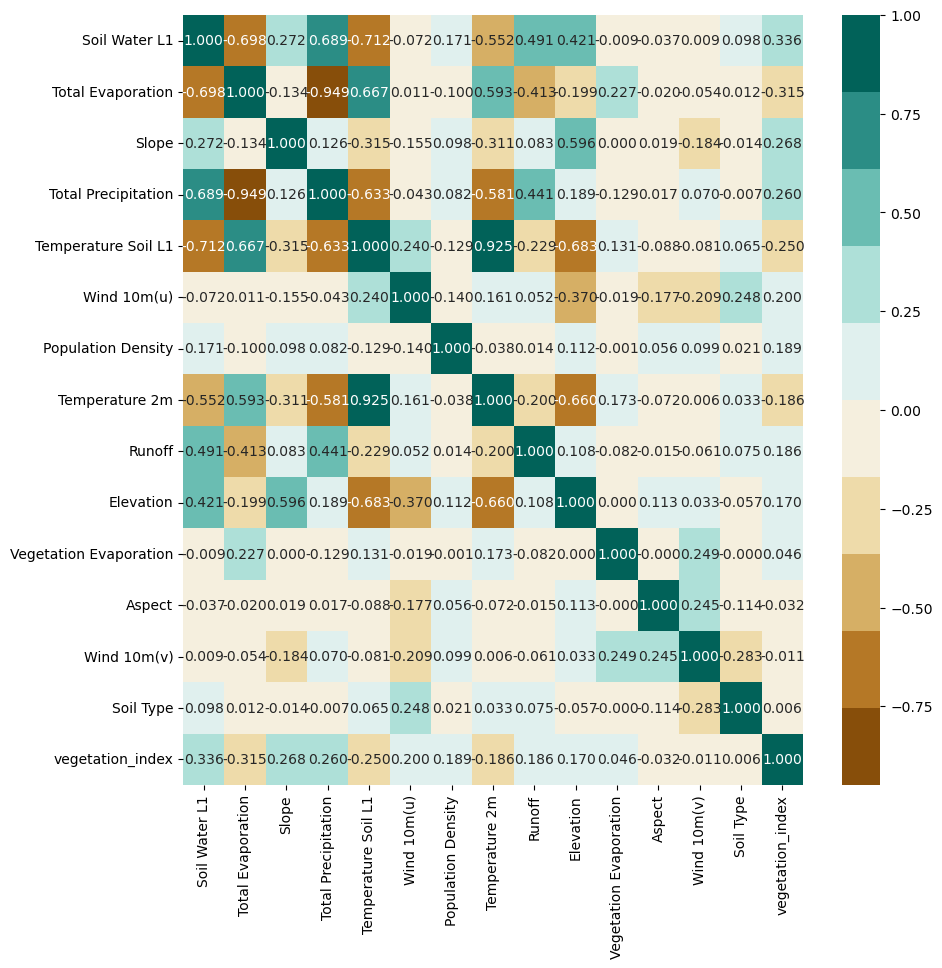

In [16]:
import seaborn as sns
corr_matrix = df.corr()

# Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))

# Generate Color Map
colormap = sns.color_palette("BrBG", 10)

# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".3f")
plt.show()

Remove iteratively the features that have a correlation higher than *threshold* with a precedenting feature

In [21]:
col_nbr = df.shape[1]
# Set your correlation threshold
threshold = 0.9  
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            if colname != 'vegetation_index':
                correlated_features.add(colname)      
                col_nbr =-1
                print(f"Remove ferature '{colname}'")
            
df_filtered = df.drop(columns=correlated_features)
df_filtered.dropna(inplace=True)
filtered_columns = df_filtered.columns
print(f"Remaining features: {list(filtered_columns)}")

Remove ferature 'Total Precipitation'
Remove ferature 'Temperature 2m'
Remaining features: ['Soil Water L1', 'Total Evaporation', 'Slope', 'Temperature Soil L1', 'Wind 10m(u)', 'Population Density', 'Runoff', 'Elevation', 'Vegetation Evaporation', 'Aspect', 'Wind 10m(v)', 'Soil Type', 'vegetation_index']


Build and train a Random Forest Regressor

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import operator
#important_features = []
X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop(["vegetation_index"], axis=1), df_filtered["vegetation_index"], test_size=0.2)
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestRegressor()

Calculate the MSE (mean squared error) on the test data

In [25]:
y_pred = clf.predict(X_test)
# Calculate and display Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.8f}")

Mean Squared Error: 0.00012717


Output the RF feature importance 

Wind 10m(u): 0.1448
Soil Water L1: 0.1399
Slope: 0.0986
Total Evaporation: 0.0986
Wind 10m(v): 0.0911
Vegetation Evaporation: 0.0856
Population Density: 0.0787
Elevation: 0.0742
Runoff: 0.0714
Temperature Soil L1: 0.0631
Aspect: 0.0461
Soil Type: 0.0079


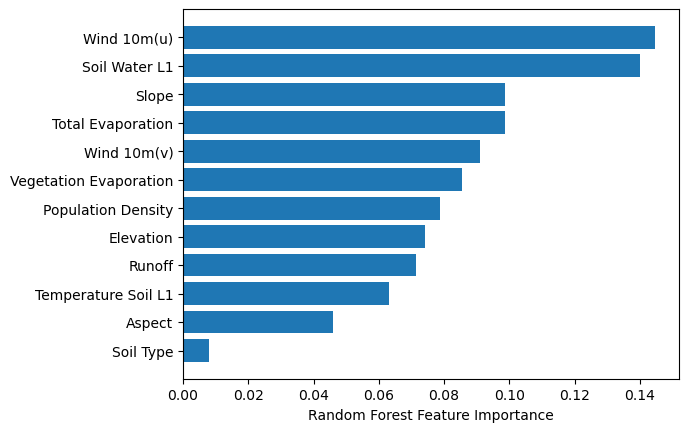

In [26]:
res = sorted(zip(filtered_columns, clf.feature_importances_), key = operator.itemgetter(1), reverse=True)
for name, importance in res:
     print(f"{name}: {importance:.4f}")
fcol = filtered_columns[:-1]
sorted_idx = clf.feature_importances_.argsort()
plt.barh([fcol[i] for i in sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig('./figures/rf_importance_region_'+str(region_id)+'.png',bbox_inches='tight')
plt.show()

Apply the permutation importance method to calculate the importance of each feature

In [27]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = perm_importance.importances_mean.argsort()

Wind 10m(u): 0.4113
Total Evaporation: 0.2504
Soil Water L1: 0.2486
Vegetation Evaporation: 0.2350
Slope: 0.1885
Wind 10m(v): 0.1525
Population Density: 0.1478
Runoff: 0.1372
Elevation: 0.1265
Temperature Soil L1: 0.1070
Aspect: 0.0422
Soil Type: 0.0231


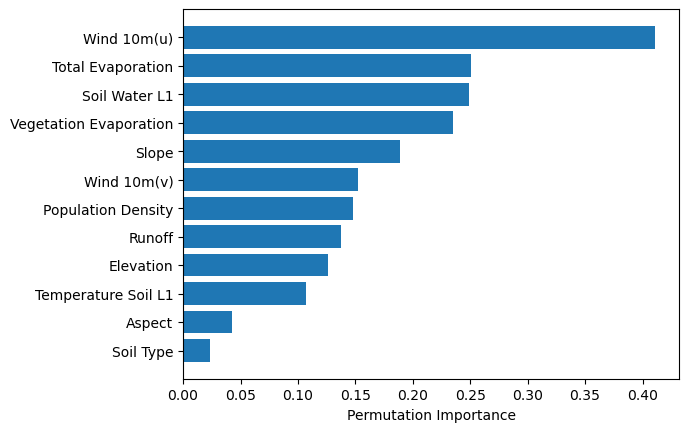

In [28]:
sorted_idx_r = sorted_idx[::-1]
for i in range(len(sorted_idx_r)):
    print(f"{fcol[sorted_idx_r[i]]}: {perm_importance.importances_mean[sorted_idx][len(sorted_idx_r)-i-1]:.4f}")
plt.barh([fcol[i] for i in sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig('./figures/permutation_bar_region_'+str(region_id)+'.png',bbox_inches='tight')
plt.show()

Display permutation importance results in a rose plot

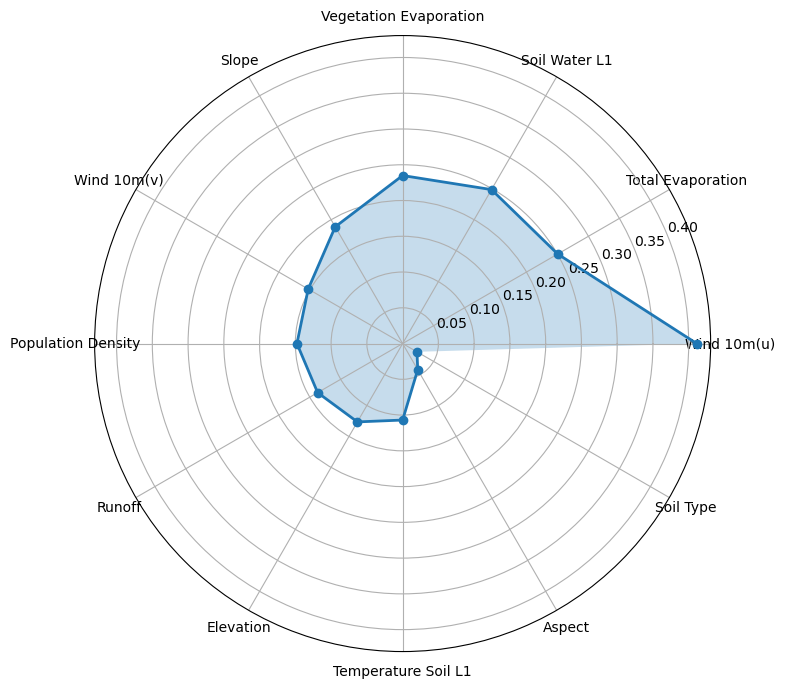

In [29]:
num_features = len(sorted_idx)
# Create a radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
# Compute angle of each feature
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
# Plot data on the radar chart
ax.plot(angles, perm_importance.importances_mean[sorted_idx_r], 'o-', linewidth=2, label='Importance')
ax.fill(angles, perm_importance.importances_mean[sorted_idx_r], alpha=0.25)
# Set feature labels
ax.set_thetagrids(np.degrees(angles), [fcol[i] for i in sorted_idx_r])
# Display the plot
plt.savefig('./figures/permutation_rose_region_'+str(region_id)+'.png',bbox_inches='tight')
plt.show()

Calculate Shaply values using the Tree Explainer

In [31]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Display a bar plot of global feature importances

In [ ]:
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('./figures/shap_features_region_'+str(region_id)+'.png',bbox_inches='tight')
plt.show()

Display a beeswarm plot that provides an information-rich summary of how the features affect the model output. Each instance of the given explanation is represented by a single point on each feature row. The x-position of the point is determined by the SHAP value of that feature, and the points "pile up" along each feature row to indicate density. Color is used to indicate the original value of a feature.

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False,title=None)
plt.xlabel("Impact on model output")
plt.savefig('./figures/shap_bar_region_'+str(region_id)+'.png',bbox_inches='tight')
plt.show()